In [9]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import dask.dataframe as dd 
import numpy as np

pd.set_option('display.max_rows', 100)  # Replace 100 with the desired number
pd.set_option('display.max_columns', 200)  # Replace 100 with the desired number

In [148]:
def read_and_filter_csv_files(folder_path):
    # Columns to be read
    cols = ['props_pageProps_address_buildings_0_bathroomCondition', 
            'props_pageProps_address_buildings_0_buildingName',
            'props_pageProps_address_buildings_0_externalWallMaterial', 
            'props_pageProps_address_buildings_0_heatingInstallation',
            'props_pageProps_address_buildings_0_housingArea', 
            'props_pageProps_address_buildings_0_kitchenCondition', 
            'props_pageProps_address_buildings_0_numberOfFloors',
            'props_pageProps_address_buildings_0_numberOfToilets', 
            'props_pageProps_address_buildings_0_roofingMaterial', 
            'props_pageProps_address_buildings_0_toiletCondition',
            'props_pageProps_address_buildings_0_yearBuilt', 
            'props_pageProps_address_municipality_name', 
            'props_pageProps_address_coordinates_lat', 
            'props_pageProps_address_coordinates_lon',
            'props_pageProps_address_events_0_at',
            'props_pageProps_address_events_0_label', 
            'props_pageProps_dataLayer_virtualPagePath', 
            #'props_pageProps_dataLayer_detailPropertyClass', 
            'props_pageProps_dataLayer_detailMetaData']

    # List to hold the filtered DataFrames
    filtered_dfs = []

    # Process each CSV file in the folder
    for file in os.listdir(folder_path):
        if file.endswith('properties.csv'):
            file_path = os.path.join(folder_path, file)
            print(file)
            df = dd.read_csv(file_path, usecols=cols, sample=10000000, assume_missing=True, dtype=str)

            # Compute to Pandas DataFrame and apply filter
            df_computed = df.compute()
            df_filtered = df_computed[df_computed['props_pageProps_address_events_0_label'] == 'Fri handel']
            
            # Find the mode and filter
            mode = df_filtered['props_pageProps_address_municipality_name'].mode()[0]
            df_filtered = df_filtered[df_filtered['props_pageProps_address_municipality_name'] == mode]
            print(mode)

            filtered_dfs.append(df_filtered)

    # Concatenate all DataFrames
    concatenated_df = pd.concat(filtered_dfs, ignore_index=True)
    return concatenated_df

In [17]:
#concatenated_df = read_and_filter_csv_files('../../bigData')

concatenated_df = pd.read_csv('cleanedNewTest.csv')

In [18]:
concatenated_df['props_pageProps_address_municipality_name'].value_counts()

props_pageProps_address_municipality_name
Frederiksberg    3087
Ishøj            2146
Halsnæs          1607
Dragør           1436
Vallensbæk       1399
Fredensborg      1161
Allerød          1110
Brøndby           561
Rødovre           422
Name: count, dtype: int64

In [19]:
concatenated_df.isnull().sum()

props_pageProps_address_buildings_0_bathroomCondition       0
props_pageProps_address_buildings_0_buildingName            0
props_pageProps_address_buildings_0_externalWallMaterial    0
props_pageProps_address_buildings_0_heatingInstallation     0
props_pageProps_address_buildings_0_housingArea             0
props_pageProps_address_buildings_0_kitchenCondition        0
props_pageProps_address_buildings_0_numberOfFloors          0
props_pageProps_address_buildings_0_numberOfToilets         0
props_pageProps_address_buildings_0_roofingMaterial         0
props_pageProps_address_buildings_0_toiletCondition         0
props_pageProps_address_buildings_0_yearBuilt               0
props_pageProps_address_coordinates_lat                     0
props_pageProps_address_coordinates_lon                     0
props_pageProps_address_municipality_name                   0
props_pageProps_address_events_0_at                         0
props_pageProps_address_events_0_label                      0
props_pa

In [20]:
# Convert to numeric and datetime with coercion
concatenated_df['props_pageProps_address_buildings_0_housingArea'] = pd.to_numeric(concatenated_df['props_pageProps_address_buildings_0_housingArea'], errors='coerce')
concatenated_df['props_pageProps_address_buildings_0_numberOfFloors'] = pd.to_numeric(concatenated_df['props_pageProps_address_buildings_0_numberOfFloors'], errors='coerce', downcast='integer')
concatenated_df['props_pageProps_address_buildings_0_numberOfToilets'] = pd.to_numeric(concatenated_df['props_pageProps_address_buildings_0_numberOfToilets'], errors='coerce', downcast='integer')
concatenated_df['props_pageProps_address_buildings_0_yearBuilt'] = pd.to_numeric(concatenated_df['props_pageProps_address_buildings_0_yearBuilt'], errors='coerce', downcast='integer')
concatenated_df['props_pageProps_address_coordinates_lat'] = pd.to_numeric(concatenated_df['props_pageProps_address_coordinates_lat'], errors='coerce')
concatenated_df['props_pageProps_address_coordinates_lon'] = pd.to_numeric(concatenated_df['props_pageProps_address_coordinates_lon'], errors='coerce')
concatenated_df['props_pageProps_address_events_0_at'] = pd.to_datetime(concatenated_df['props_pageProps_address_events_0_at'], errors='coerce')

In [21]:
concatenated_df.isnull().sum()

props_pageProps_address_buildings_0_bathroomCondition       0
props_pageProps_address_buildings_0_buildingName            0
props_pageProps_address_buildings_0_externalWallMaterial    0
props_pageProps_address_buildings_0_heatingInstallation     0
props_pageProps_address_buildings_0_housingArea             0
props_pageProps_address_buildings_0_kitchenCondition        0
props_pageProps_address_buildings_0_numberOfFloors          0
props_pageProps_address_buildings_0_numberOfToilets         0
props_pageProps_address_buildings_0_roofingMaterial         0
props_pageProps_address_buildings_0_toiletCondition         0
props_pageProps_address_buildings_0_yearBuilt               0
props_pageProps_address_coordinates_lat                     0
props_pageProps_address_coordinates_lon                     0
props_pageProps_address_municipality_name                   0
props_pageProps_address_events_0_at                         0
props_pageProps_address_events_0_label                      0
props_pa

In [22]:
# Extract price from string

def extract_last_price(s):
    last_price_match = re.search(r'lastPrice:(\d+)', s)
    return int(last_price_match.group(1)) if last_price_match else None

concatenated_df['lastPrice'] = concatenated_df['props_pageProps_dataLayer_detailMetaData'].apply(extract_last_price)
concatenated_df['sqm_price'] = concatenated_df['lastPrice'] / concatenated_df['props_pageProps_address_buildings_0_housingArea']

concatenated_df['years_from_today'] = pd.Timestamp.now().year - concatenated_df['props_pageProps_address_events_0_at'].dt.year

concatenated_df.drop('props_pageProps_dataLayer_detailMetaData', axis=1, inplace=True)

# Consider fill with mean and mode
concatenated_df = concatenated_df.dropna(how='any')

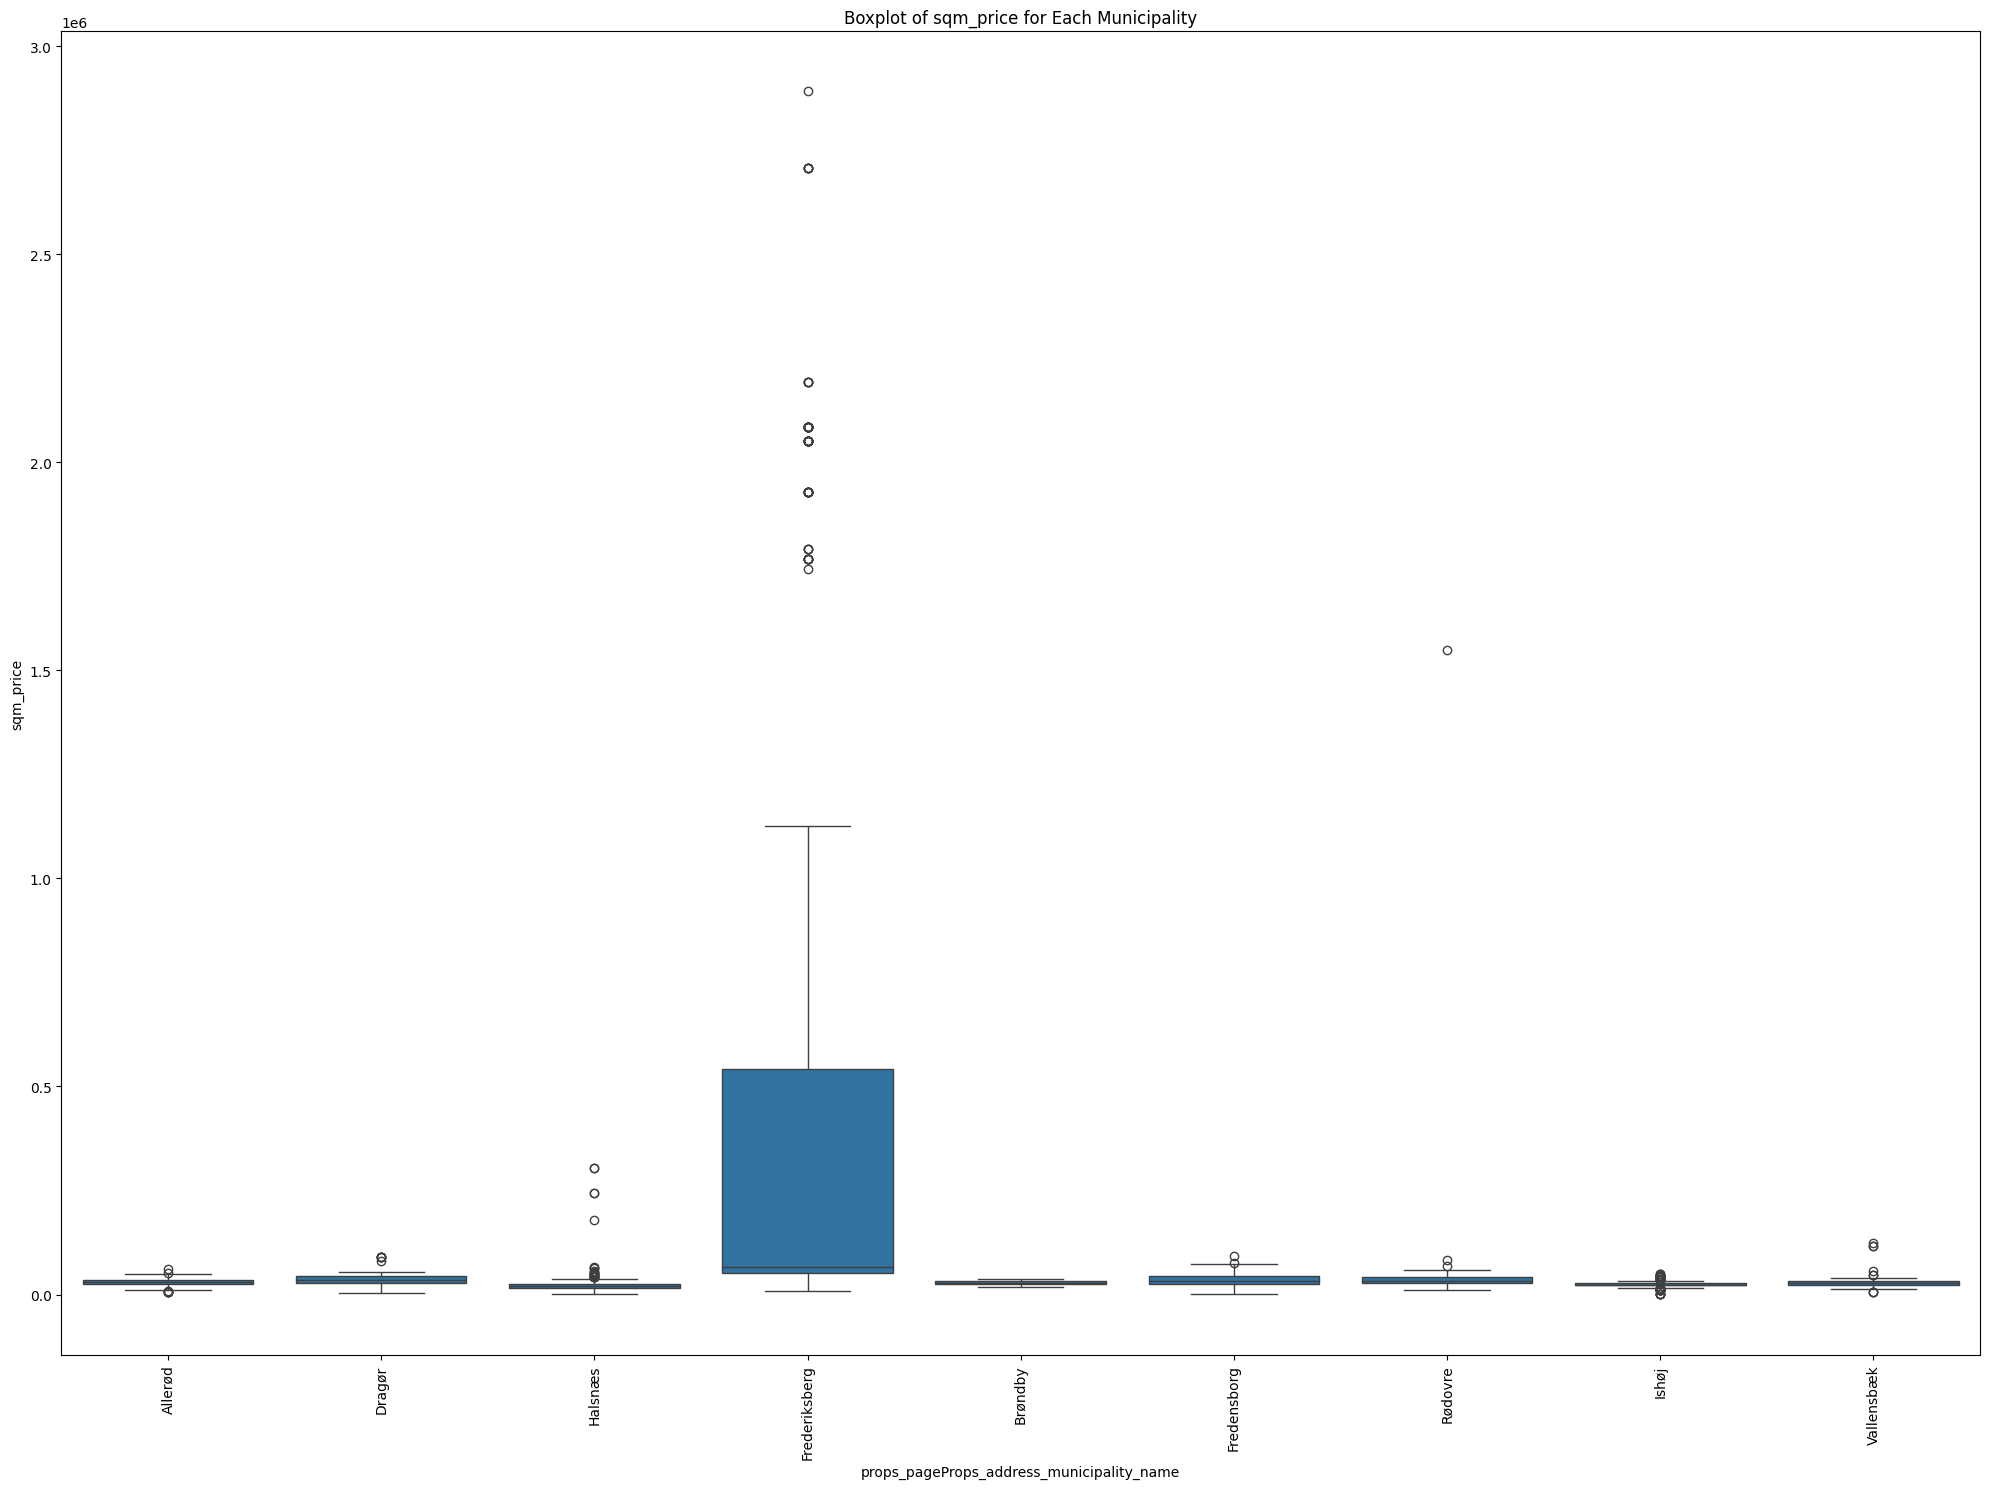

In [24]:
import seaborn as sns

# Check for last 3 years to avoid inflation correction
last_3_years = concatenated_df[concatenated_df['years_from_today'] < 3]

# Filter the DataFrame to include only 'municipality_name' and 'sqm_price'
municipality_sqm_price = last_3_years[['props_pageProps_address_municipality_name', 'sqm_price']]

# Plotting boxplots for 'sqm_price' for each 'municipality_name'
plt.figure(figsize=(20, 15))  # Adjust the size as needed
sns.boxplot(x='props_pageProps_address_municipality_name', y='sqm_price', data=municipality_sqm_price)
plt.xticks(rotation=90)  # Rotate x labels for better visibility
plt.title('Boxplot of sqm_price for Each Municipality')
plt.tight_layout()
plt.show()

# Instead of removing them, we could handle them in clustering where we label them as "High value property" for example. These outliers could be newly renovated properties or 

In [158]:
concatenated_df.head()

,props_pageProps_address_buildings_0_bathroomCondition,props_pageProps_address_buildings_0_buildingName,props_pageProps_address_buildings_0_externalWallMaterial,props_pageProps_address_buildings_0_heatingInstallation,props_pageProps_address_buildings_0_housingArea,props_pageProps_address_buildings_0_kitchenCondition,props_pageProps_address_buildings_0_numberOfFloors,props_pageProps_address_buildings_0_numberOfToilets,props_pageProps_address_buildings_0_roofingMaterial,props_pageProps_address_buildings_0_toiletCondition,props_pageProps_address_buildings_0_yearBuilt,props_pageProps_address_coordinates_lat,props_pageProps_address_coordinates_lon,props_pageProps_address_municipality_name,props_pageProps_address_events_0_at,props_pageProps_address_events_0_label,props_pageProps_dataLayer_virtualPagePath,lastPrice,sqm_price,years_from_today
0,Badeværelse i enheden,"(UDFASES) Række-, kæde- eller dobbelthus (lodr...",Mursten,Centralvarme med én fyringsenhed,101.0,Eget køkken med afløb,1,1,Betontagsten,Vandskyllende toilet i enheden,2014,55.88093,12.345663,Allerød,2014-11-07 00:00:00+00:00,Fri handel,/adresse/williamsvej-18-3450-alleroed-02019645...,2545000.0,25198.019802,9
2,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Centralvarme med én fyringsenhed,141.0,Eget køkken med afløb,1,1,Fibercement herunder asbest,Vandskyllende toilet i enheden,1964,55.87107,12.352669,Allerød,2018-03-02 00:00:00+00:00,Fri handel,/adresse/aggebovej-11-3450-alleroed-02010099__...,3745000.0,26560.283688,5
3,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Centralvarme med én fyringsenhed,139.0,Eget køkken med afløb,1,1,Tegl,Vandskyllende toilet i enheden,1949,55.87164,12.352702,Allerød,2020-09-18 00:00:00+00:00,Fri handel,/adresse/aggebovej-17-3450-alleroed-02010099__...,2300000.0,16546.76259,3
4,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Centralvarme med én fyringsenhed,168.0,Eget køkken med afløb,1,2,Tegl,Vandskyllende toilet i enheden,1950,55.871815,12.353047,Allerød,2017-07-05 00:00:00+00:00,Fri handel,/adresse/aggebovej-21-3450-alleroed-02010099__...,4100000.0,24404.761905,6
5,Badeværelse i enheden,Fritliggende enfamilieshus (parcelhus),Mursten,Centralvarme med én fyringsenhed,120.0,Eget køkken med afløb,1,2,Tegl,Vandskyllende toilet i enheden,1947,55.87149,12.353259,Allerød,2017-11-16 00:00:00+00:00,Fri handel,/adresse/aggebovej-22-3450-alleroed-02010099__...,2120393.0,17669.941667,6


In [156]:
concatenated_df.to_csv('cleanedNewTest.csv', index = False)